# Tutorial 4: Accessing thermodynamic properties from sampling methods

In this tutorial you will learn how to calculate thermodynamic  properties by using the Metropolis Monte-Carlo method or the Wang-Landau method. The application of both sampling methods will be demonstrated on the Pt/Cu(111) surface alloy.

The essential elements to carry out a sampling procedure are:

- a cluster expansion (CE) model for the energy

- spezification of the simulation cell

As CE model for the energy of the Pt/Cu(111) surface alloy, we use a CE [model](https://sol.physik.hu-berlin.de/cell/modules/model.html) that can be downloaded [here](https://sol.physik.hu-berlin.de/cell/tutorials/tutorials.html#notecemodel). You can also build the model yourself with the python script that is provided [here](https://sol.physik.hu-berlin.de/cell/tutorials/tutorials.html#notecemodel). This can be initialized from the file "model-PtCu-2.pickle" with:

In [1]:
from clusterx.model import Model
cemodelE = Model(filepath = "model-PtCu-2.pickle")

$E_{\rm ads}$ predicted by this CE model is given in units of $eV$ per subsitutional site, short $eV/site$. How this CE model is obtained, is described in detail in [tutorial_CE_Pt/Cu(111)](https://sol.physik.hu-berlin.de/cell/tutorials_CE_Pt-Cu111.html).

Now, we use the [parent lattice](https://sol.physik.hu-berlin.de/cell/modules/parent_lattice.html) for which the CE model is based on to create the simulation cell. Our simulation cell is an object of the class [SuperCell](https://sol.physik.hu-berlin.de/cell/modules/super_cell.html), and can be initialized as:

In [7]:
# Intialization of the SuperCell object being the simulation cell
from clusterx.super_cell import SuperCell
scell = SuperCell(cemodelE.get_plat(),[[4,0],[-2,4]])

# Display information of the SuperCell object
scell.get_sublattice_types(pretty_print=True)
sites_dict = scell.get_nsites_per_type()
for key in sites_dict.keys():
    print("Number of atoms in sublattice "+str(key)+":", sites_dict[key])

from clusterx.visualization import juview
juview(scell)


+--------------------------------------------------------------------+
|              The structure consists of 2 sublattices               |
+--------------------------------------------------------------------+
| Sublattice type |       Chemical symbols       |  Atomic numbers   |
+--------------------------------------------------------------------+
|        0        |            ['Cu']            |       [29]        |
|        1        |         ['Cu' 'Pt']          |      [29 78]      |
+--------------------------------------------------------------------+

Number of atoms in sublattice 0: 32
Number of atoms in sublattice 1: 16


As we see from the displayed information, the supercell consists of two sublattices, with indices  0 and  1. Both sublattices contain species "Cu". In sublattice 0, they can not be substituted, while in sublattice 1 that contains all sites of one (111) surface, "Cu" can be substituted by "Pt". 
This simulation cell has, in total, 16 substitutional surface sites:

In [8]:
nsites = len(scell.get_substitutional_atoms())
print(nsites)

16


## Metropolis Monte-Carlo sampling

In the following, we perform a Metropolis Monte-Carlo (MMC) sampling [N. Metropolis *et. al.*, *J. Chem. Phys.* **21**, 1087 (1953)] in the canonical ensemble, i.e. the volume of the simulation cell, the composition and the temperature remain unchanged. During such a sampling algorithm, a sequence of configurations is generated by modifying the configuration at each step by one or multiple swaps of two randomly-choosen species in the substitutional lattice(s). After a swap, the new proposed structure with energy $E_1$ is accepted with the probability

\begin{equation*}
P ( E_0 \rightarrow E_1) = \min \left[ \exp \left( - \frac{E_1-E_0}{k_{\rm B} T} \right) , 1 \right].
\end{equation*} 

Here, $E_0$ is the energy of the structure before the swap. 
This acceptance probability distribution depends on the Boltzmann probability distribution $\exp \left( - \frac{E}{k_{\rm B} T} \right)$ at given temperature $T$ and the Boltzmann constant $k_{\rm B}$.

For canonical samplings in the surface alloy Pt/Cu(111), we choose a composition with 4 Pt atoms, e.g. a Cu$_3$Pt alloy in the surface layer. Now, we perform a MMC sampling at $T=300\,$K with:

In [9]:
nsubs = {0:[4]}
kb = float(8.6173303*10**(-5)) # Boltzmann constant in eV/K
temp = 300 # Temperature in K

# Initialization of a MonteCarlo object
from clusterx.thermodynamics.monte_carlo import MonteCarlo
mc = MonteCarlo(cemodelE, \
                scell, \
                ensemble = "canonical", \
                nsubs = nsubs, \
                predict_swap = True)

# Execution of a Metropolis Monte-Carlo sampling
traj = mc.metropolis(no_of_sampling_steps = 1000, \
                     temperature = 800, \
                     boltzmann_constant = kb, \
                     scale_factor = [1/(1.0*nsites)])

In the first three lines, we define the number of Pt atoms in the substitutional lattice 1 by `nsubs`, $k_{\rm B}$ and $T$. Afterwards, we load the [MonteCarlo](https://sol.physik.hu-berlin.de/cell/modules/monte_carlo.html) class, and create an object of this class, called `mc`. The initialization of this object requires the CE model for the energy `cemodelE`, the simulation cell `scell`, and for a canonical sampling the composition defined by `nsubs`. As an option, you can put `predict_swap=True` to speed up the sampling time (more details are given in the description of the class [MonteCarlo](https://sol.physik.hu-berlin.de/cell/modules/monte_carlo.html)). 
The object `mc` contains the main components to set up a sampling procedure, but does not perform a sampling by itself and is temperature independent.  

Using the object `mc`, the MMC sampling can be executed with the method `metropolis`. As arguments, it needs the number of sampling steps `no_of_sampling_step`, $T$ `temperature`, and $k_{\rm B}$ `boltzmann_constant`. Here, the product $k_{\rm B}T$ has to have the same units as the energies predicted by the CE model `cemodelE`. 
In our case, the units of $E_{\rm ads}$ are $eV/sites$, while the the product $k_{\rm B}T$ is given in units of $eV$. To obtain the same units for $k_{\rm B}T$, we make use of the optional argument `scale_factor`. `scale_factor` is a list of arbitrary length containing float numbers. The product of the floats is multiplied to $k_{\rm B}T$. Thus, to get the units $eV/sites$, we use `scale_factor=[1/nsites]`. 

The `metropolis` creates an object of the class `MonteCarloTrajectory` that stores all information of the trajectory generated from the MMC sampling. This object, named `traj` in the code above, is used to access this information after the MMC sampling. In the following, we show some examples how to obtained certain properties from the `traj` object (for more details please see the description of the class [MonteCarloTrajectory](https://sol.physik.hu-berlin.de/cell/modules/monte_carlo_trajectory.html)).

Below, we visualize *e.g.* the last structure visited in the MMC sampling:

In [10]:
last_structure = traj.get_structure(-1)

#from clusterx.visualization import juview
juview(last_structure)

In the code shown below, we visualize the first three accepted structures in the sampling. For this, we first get the list of the accepted steps from the method `get_sampling_step_nos`. Then, in a `for` loop over the first three accepted steps of this list, `Structure` objects at these steps are created and stored. At the end the stored structures are visualized:

In [12]:
steps_accepted = traj.get_sampling_step_nos()

first_three_accepted_structures = []
for step in steps_accepted[:3]:
        struc = traj.get_structure_at_step(step)
        first_three_accepted_structures.append(struc)

from clusterx.visualization import juview
#juview(last_structure)
juview(first_three_accepted_structures)

We can extract the energies of the accepted MMC steps with the method `get_energies` and plot them versus the sampling step number:

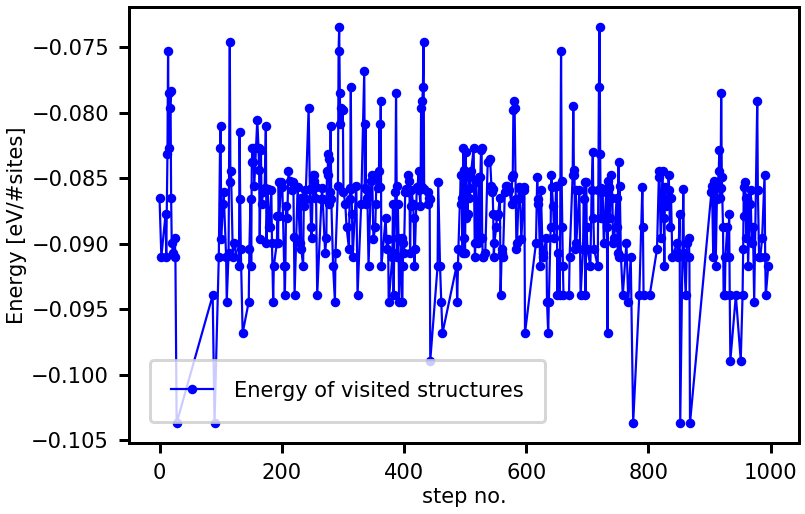

In [13]:
energies_accepted = traj.get_energies()

%matplotlib inline
from clusterx.visualization import plot_property
plot_property(steps_accepted, energies_accepted, \
             prop_name = "Energy of visited structures", \
             xaxis_label = "step no.", yaxis_label = "Energy [eV/#sites]")

Next, we want to use the MMC method to study thermodynamic properties of the CuPt(111) surface alloy, as *e.g.* the isobaric specific heat $C_p$. 

$C_p$ can be calculated from the MMC trajectory `traj` by the method `calculate_average_property`. As arguments, we define the property that we want to obtain with `prop_name`, in our case `"C_p"` for the specific heat, and the number of equilibration steps `no_of_equilibration_steps` that are discarded at the beginning of the sampling trajectory from the average, in our case we choose 100 equilibration steps. 

In [14]:
cp = traj.calculate_average_property(prop_name = "C_p", \
                                no_of_equilibration_steps = 100)
print("Specific heat for",temp,"K:", cp, "k_B/#sites")

Specific heat for 300 K: 0.10164517942599213 k_B/#sites


This single value does not say much. To study the temperature dependence of $C_p$, we need to perform MMC samplings in a range of temperatures. This is done in the following piece of code (be aware that this sampling takes a few minutes):

In [18]:
temp_list = []
cp_list = []

# Simulated annealing
for i,temp in enumerate(range(1400,0,-100)):
    if i == 0:
        init_structure = scell.gen_random(nsubs=nsubs)
    traj = mc.metropolis(no_of_sampling_steps = 1000, \
                         temperature = temp, \
                         boltzmann_constant = kb, \
                         scale_factor = [1/(1.0*nsites)], \
                         initial_decoration = init_structure.get_atomic_numbers())
    cp = traj.calculate_average_property(prop_name = "C_p", \
                         no_of_equilibration_steps = 200)
    
    print("Sampling at temperature ", temp, "K gives a specific heat of ", cp)
    temp_list.append(temp)
    cp_list.append(cp)
    init_structure = traj.get_structure(-1)
    

Sampling at temperature  1400 K gives a specific heat of  0.027353887641240214
Sampling at temperature  1300 K gives a specific heat of  0.03679968095733418
Sampling at temperature  1200 K gives a specific heat of  0.04247668684048657
Sampling at temperature  1100 K gives a specific heat of  0.05094406465862546
Sampling at temperature  1000 K gives a specific heat of  0.07468717007690714
Sampling at temperature  900 K gives a specific heat of  0.07628716451360108
Sampling at temperature  800 K gives a specific heat of  0.07990603709147324
Sampling at temperature  700 K gives a specific heat of  0.2039298875821653
Sampling at temperature  600 K gives a specific heat of  0.286716279255121
Sampling at temperature  500 K gives a specific heat of  0.33938655839719717
Sampling at temperature  400 K gives a specific heat of  0.0031864985531503843
Sampling at temperature  300 K gives a specific heat of  2.0697699861960484e-26
Sampling at temperature  200 K gives a specific heat of  3.987845981

With the code above, a simulated annealing is performed. *I.e.* the `for` loop starts from a reasonable high temperature of $T=1400\,$K and gradually decreases $T$ in steps of $100\,$K. For each temperature, an MMC sampling is performed and the $C_p$ calculated. After each sampling, the last structure is stored as `init_structure` in order to use it as initial structure for the following MMC sampling. Here, for the first temperature, the MMC starts from a random structure (initialized with the `if` case).


After the simulated annealing, we can visualize the lowest-energy structure visited at the last sampled temperature of $T=100\,$K with:

In [19]:
juview(traj.get_lowest_energy_structure())

This structure is expected to show an ordered pattern. For the surface stoichiometry of Cu$_3$Pt, a $p(2\times2)$ ordering is expected accoring to Ref. [F. R. Lucci *et. al.*, J. Phys. Chem. C **118**, 6, 3015 (2014)]. If your result is not showing this ordering, it can be due to an insufficent number of sampling steps.

The plot below shows the $C_p$ versus temperature obtained from the simulated annealing. 
For a phase transition from an ordered ground state to disorderd state, $C_p$ is expected to have a maximum at the transition temperature.

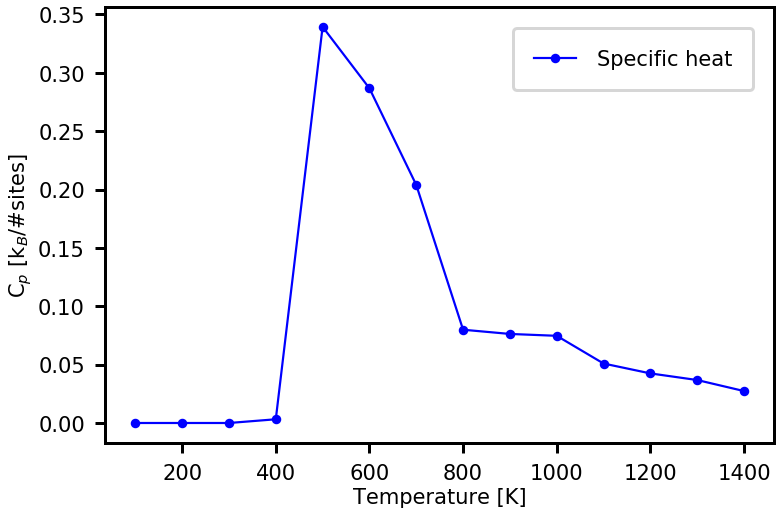

In [20]:
plot_property(temp_list, cp_list, \
             prop_name = "Specific heat", \
             xaxis_label = "Temperature [K]", yaxis_label = r'C$_p$ [k$_B$/#sites]')

The parameters of the MMC samplings above are chosen to achieve fast samplings and give only rough estimates of actual properties of the system. 

To determine a precise transition temperature of the order-disorder phase transition for the Pt/Cu(111) surface alloy, *e.g.* MMC samplings with larger sampling steps, in total, are required (see **Excercises** at the end). 
As another possibility to access thermodynamic properties, we present in the next section the Wang-Landau method.


## Wang-Landau method

As an alternative to the MMC sampling, we present the Wang-Landau (WL) method [F. Wang and D. P. Landau, *Phys. Rev. Lett.* **86**, 2050 (2001)]. Instead of performing temperature-dependent samplings, this methods obtains directly the temperature-independent configurational density of states $g(E)$ from a single sampling procedure. Once the $g(E)$ is known, thermodynamic properties at any desired temperature can directly be calculated. 

**Short introduction into the Wang-Landau method:** In the WL sampling, the new structure proposed by a random swap of atoms with energy $E_1$ and corresponding $g(E_1)$ is accepted with the probability
\begin{equation*}
P(E_0 \rightarrow E_1) = \min \left[ 1, \frac{g(E_0)}{g(E_{1})} \right]
\end{equation*}
Here, $E_0$ and $g(E_0)$ are the energy and the corresponding configurational density of states of the previous structure. 
The acceptance probability is proportional to $1/g(E)$. If the true $g(E)$ is used in $P(E_0 \rightarrow E_1)$, the sampling generates a flat histogram. Upon reversion, it means that if a sampling generates a flat histogram, the $g(E)$ is close to the true $g(E)$.

As a starting point for such a sampling, the complete energy space, that can be visited during a canonical sampling, is discretized into energy bins with predefined width $\Delta E$. The $g(E)$ of those bins is unknown, thus it is initially set to $g(E)=1$ for all bins. Furthermore, the histogram of the sampling is initially set to $H(E)=0$ (no visits). At each sampling step, independent of the acceptance or rejection of the new structure, $g(E)$ and $H(E)$ of the currently visited structure are updated with $g(E)=g(E) \cdot f$ and $H(E)=H(E)+1$. Here, $f$ is the so-called modification factor, which is initially set to $f=\exp(1)$. The sampling algorithm performs a nested loop consisting of an inner loop to generate a flat histogram for a given $f$ and an outer loop that lowers $f$ (usually by $f \rightarrow \sqrt{f}$ in each iteration). The accuracy of the final $g(E)$ depends on $f$ and the flatness of the histogram. A histogram is considered as flat if the minimum of $H(E)$ is larger than a fraction $x$ of the mean value of $H(E)$, *i.e.* $\min H(E) > x \cdot \bar{H}(E)$. This fraction is usually $x=0.5$ for the first iterations in the outer loop and is increased up to $x=0.98$ in the last iterations (depends highly on the complexity of the system). Details about this method can be found in Ref. [F. Wang and D. P. Landau, *Phys. Rev. Lett.* **86**, 2050 (2001)] and [D. P. Landau *et. al.*, *Am. J. Phys.* **72**, 1294 (2004)]. 

In the following, we use the class [WangLandau](https://sol.physik.hu-berlin.de/cell/modules/wang_landau.html) to obtain the $g(E)$ for surface alloy Pt/Cu(111) at the stoichiometry of Cu$_3$Pt, *i.e.* 4 Pt atoms in the 16 surface sites (be aware that the execution of the following code lines take a few minutes).

In [22]:
nsubs={0:[4]}
emin = 12.7
emax = 13.9

# Initialization of a WangLandau object
from clusterx.thermodynamics.wang_landau import WangLandau
wl = WangLandau(cemodelE, 
                scell, 
                ensemble = "canonical", 
                nsubs = nsubs, 
                predict_swap = True,
                error_reset=None)

import numpy as np
# Execution of the Wang-Landau sampling
cdos = wl.wang_landau_sampling(energy_range = [emin, emax], 
                               energy_bin_width = 0.025,
                               f_range = [np.exp(1), np.exp(1e-2)], 
                               flatness_conditions=[
                                    [0.8,np.exp(1e-1)],
                                    [0.90,np.exp(1e-3)],
                                    [0.95,np.exp(1e-5)]
                                ],
                               serialize = True,
                               serialize_during_sampling = True, 
                               filename = 'cdos.json')

In the first line, we define the number of Pt atoms in the substitutional lattice 1 by `nsubs`. Afterwards, we initialize an object `wl` of the [WangLandau](https://sol.physik.hu-berlin.de/cell/modules/monte_carlo.html) class with the same arguments used to initialize a `MonteCarlo` object, *i.e.* the CE model for the energy `cemodelE`, the simulation cell `scell`, and the composition defined by `nsubs` (optional `predict_swap=True`).  

Using the object `wl`, the WL sampling can be executed with the method `wang_landau_sampling`. It needs the following arguments:
- the energy range `energy_range` defined by a list containing the minimum energy (first entry in list) and the maximum energy (secondt entry), that covers the complete energy space visited during the canonical sampling,
- the discretization of the energy range $\Delta E$ `energy_bin_width`,
- the range of the modification factor `f_range` defined by a list contining the initial $f$ (first entry in list) and a threshold for the final $f$ (second entry) (if the next proposed $f$ is below this threshold, the WL sampling stops),
- and optional arguments as `serialize` to serialize the `cdos` object after the sampling, `serialize_during_sampling` to serialize the `cdos` object after every iteration of the outer loop during the sampling, and `filename` to set the name of the file in which the `cdos` is stored. (more details are given in the description of the class [WangLandau](https://sol.physik.hu-berlin.de/cell/modules/monte_carlo_trajectory.html))

The returned object `cdos` is an object of the class [ConfigurationalDensityOfStates](https://sol.physik.hu-berlin.de/cell/modules/configurational_density_of_states.html) and contains all information about the $g(E)$ obained at each iteration of the outer loop in the WL algorithm. 
If the option `serialize_during_sampling` is set to `True`, the information can be accessed even during the WL sampling. This is done by reading the `ConfigurationalDensityOfStates` object from file (see code lines below). 

In the following, we show some examples how to obtained thermodynamic properties from the `wl` object (for more details please see the description of the class [ConfigurationalDensityOfStates](https://sol.physik.hu-berlin.de/cell/modules/monte_carlo_trajectory.html)).

In the first three lines of the code below, we define the temperatures, for which we want to calculate the thermodynamic properties, the Boltzmann constant $k_{\rm B}$ and also a scale factor `scale_factor` used to have the product $k_{\rm B}T$ in the same units as the CE model of the energy (here $E_{\rm ads}$ is given in units of $eV/sites$). Next, the `ConfigurationalDensityOfStates` object is read from the file `cdos.json`. This object, called `cdos_read`, is used to access $g(E)$ and to visualize $ln(g(E))$ with `plot_property`. Afterwards, the specific heat $C_p$ and the internal energy $U$ are calculated and visualized too. You will recognize that the execution of the following code line will be fast.

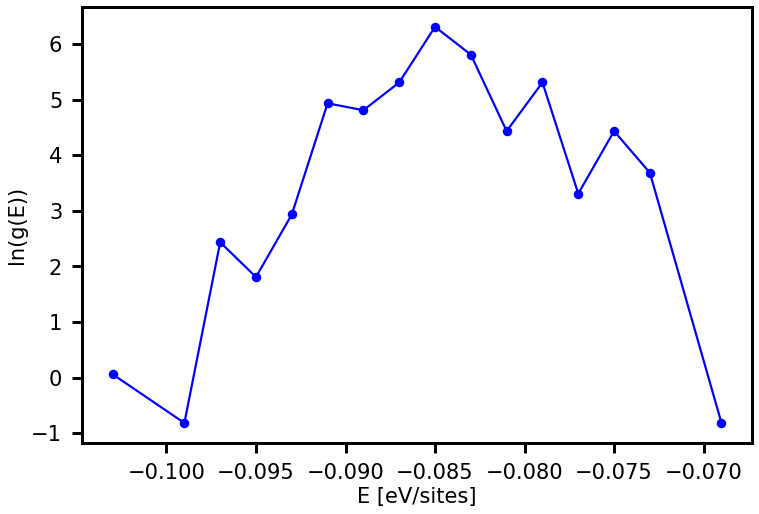

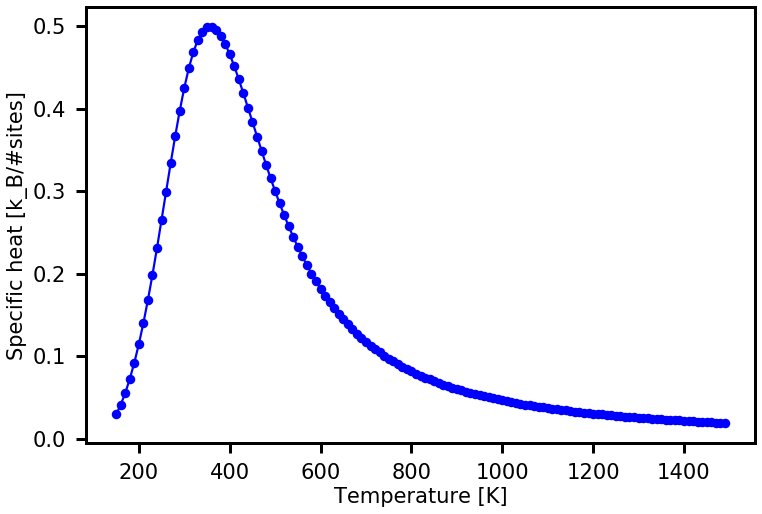

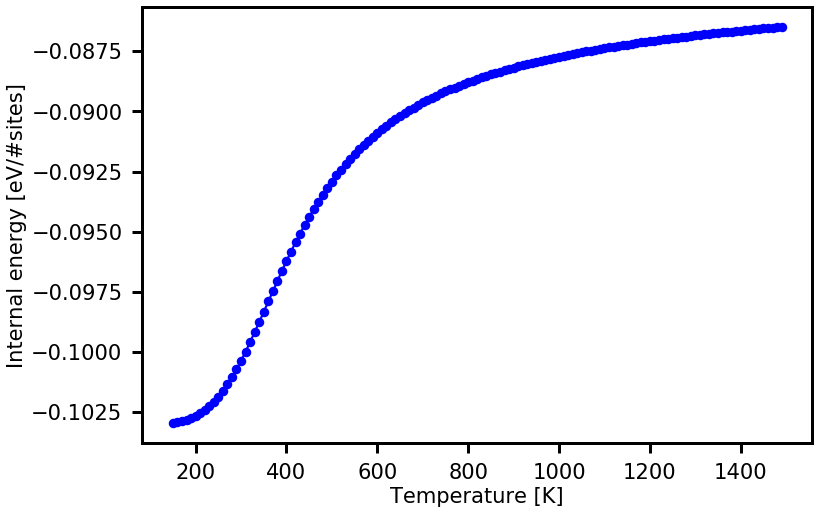

In [23]:
temps = range(150,1500,10)
scale_factor = [1/(1.0*nsites)]

# Reading of configurational density of states from file, e.g. cdos2.json as produced before
from clusterx.thermodynamics.wang_landau import ConfigurationalDensityOfStates
cdos_read = ConfigurationalDensityOfStates(filename = 'cdos.json', read = True)

e, lng = cdos_read.get_cdos(ln = True, normalization = True)
from clusterx.visualization import plot_property
plot_property(e,lng, xaxis_label = "E [eV/sites]", yaxis_label = "ln(g(E))", prop_name="lng")

cp = cdos_read.calculate_thermodynamic_property( temps, prop_name = "C_p")
plot_property(temps,cp, xaxis_label = "Temperature [K]", yaxis_label = "Specific heat [k_B/#sites]", prop_name = "C_p")

u = cdos_read.calculate_thermodynamic_property( temps, prop_name = "U")
plot_property(temps,u, xaxis_label = "Temperature [K]", yaxis_label = "Internal energy [eV/#sites]", prop_name = "U")

The $g(E)$ and the resulting thermodynamic property do not look converged yet. This is due to the fact that we choose a fairly large final modification factor of $f=\exp (0.1)$. The WL sampling usually yields converged results if the final $f$ is $\exp(0.0001)$ or even much lower (this requires a larger sampling time). 

## Excercise 6: Metropolis Monte-Carlo sampling

a. Perform a simulated annealing with a larger number of sampling steps for the MMC sampling at each temperature than it was used in the example above. 

b. Increase the simulation cell size, *e.g.* a Pt/Cu(111) surface alloy with $64$ surface sites, and repeat the simulated annealing or a single MMC sampling. How does it affect the transition temperature?

Be aware that the execution of those samplings can take up to a few days (depending on the choice of parameters).

## Excercise 7: Wang-Landau sampling

a. Choose a lower threshold for the final modification factor for the WL sampling than it was used in the example above.

b. In the method `wang_landau_sampling` of the `WangLandau` object above, we do not set explizitly the flatness condition. Look at the documentation of the class [WangLandau](https://sol.physik.hu-berlin.de/cell/modules/monte_carlo_trajectory.html) to find out which flatness conditions are used as default. The flatness condition for each iterater in the outer loop can be also read from the serialized file of the `ConfigurationalDensityOfStates` object. Try to change the modification factors.

c. Increase the simulation cell size. Is the peak of the $C_p$ changing?

Also, here, be aware that the execution of those samplings can take up to a few days (depending on the choice of parameters).